In [1]:
import os
import numpy as np
import pandas as pd
import xgboost
import xgboost as xgb
import optuna
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error 
import json


import joblib

logical_cores = os.cpu_count()
print(f"Number of logical CPU cores: {logical_cores}")

num_workers = max(1, logical_cores // 2)
print(f"Number of workers set to: {num_workers}")

def is_gpu_available():
    try:
        import torch
        return torch.cuda.is_available()
    except ImportError:
        return False

gpu_available = is_gpu_available()
print(f"GPU available: {gpu_available}")

print(xgboost.build_info())

Number of logical CPU cores: 16
Number of workers set to: 8
GPU available: True
{'BUILTIN_PREFETCH_PRESENT': False, 'CUDA_VERSION': [12, 4], 'DEBUG': False, 'MM_PREFETCH_PRESENT': True, 'THRUST_VERSION': [2, 3, 2], 'USE_CUDA': True, 'USE_DLOPEN_NCCL': False, 'USE_FEDERATED': False, 'USE_NCCL': False, 'USE_OPENMP': True, 'USE_RMM': False, 'libxgboost': 'C:\\Users\\ng_mi\\Anaconda\\envs\\pytorch-gpu\\Lib\\site-packages\\xgboost\\lib\\xgboost.dll'}


In [2]:
os.makedirs('../feature-importances/xbclassifier', exist_ok=True)
os.makedirs('../feature-importances/xbregressor', exist_ok=True)
os.makedirs('../models/hyperparameters-search-models/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/hyperparameters-search-models/xgboost/xbregressor', exist_ok=True)
os.makedirs('../models/trained-models/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/trained-models/xgboost/xbregressor', exist_ok=True)
os.makedirs('../models/best-hyperparameters/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/best-hyperparameters/xgboost/xbregressor', exist_ok=True)


path = '../data/train'

ticker_list = []

if os.path.exists(path):
    ticker_list = [os.path.splitext(f)[0] for f in os.listdir(path) if f.endswith('.csv')]


In [3]:
def load_or_create_ticker_df(csv_file_path):
    """
    Load the existing ticker DataFrame from a CSV file if it exists,
    otherwise create a new DataFrame with predefined column types.
    Ensure the DataFrame has the specified columns, add any missing columns,
    and rearrange the columns in alphabetical order, excluding 'Ticker_Symbol'.

    Args:
    csv_file_path (str): The path to the CSV file.

    Returns:
    pd.DataFrame: The loaded or newly created DataFrame.
    """
    # Define the column types
    column_types = {
        "Ticker_Symbol": str,
        "Best_Cov1D_Classification_Accuracy": float,
        "Best_Cov1D_Classification_Path": str,
        "Best_Cov1D_Regression_RMSE": float,
        "Best_Cov1D_Regression_Path": str,
        "Best_LSTM_Classification_Accuracy": float,
        "Best_LSTM_Classification_Path": str,
        "Best_LSTM_Regression_RMSE": float,
        "Best_LSTM_Regression_Path": str,
        "Best_Transformer_Classification_Accuracy": float,
        "Best_Transformer_Classification_Path": str,
        "Best_Transformer_Regression_RMSE": float,
        "Best_Transformer_Regression_Path": str,
        "Best_XGBClassifier_Classification_Accuracy": float,
        "Best_XGBClassifier_Classification_Path": str,
        "Best_XGBRegressor_Regression_RMSE": float,
        "Best_XGBRegressor_Regression_Path": str
    }


    if os.path.isfile(csv_file_path):
        # Load the existing file into a DataFrame
        ticker_df = pd.read_csv(csv_file_path)
        
        # Ensure all specified columns are present
        for column, dtype in column_types.items():
            if column not in ticker_df.columns:
                ticker_df[column] = pd.Series(dtype=dtype)
        
        # Reorder columns alphabetically, excluding 'Ticker_Symbol'
        columns = ["Ticker_Symbol"] + sorted([col for col in ticker_df.columns if col != "Ticker_Symbol"])
        ticker_df = ticker_df[columns]
    else:
        # Create a new DataFrame with the specified column types
        ticker_df = pd.DataFrame(columns=column_types.keys()).astype(column_types)
    
    return ticker_df

In [4]:
def delete_hyperparameter_search_model(ticker_symbol, model_type):
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'
    xbclassifier_model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    xbregressor_model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    xbclassifier_params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'
    xbregressor_params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'

    if model_type == "xbclassifier":
        if os.path.isfile(xbclassifier_model_path):
            os.remove(xbclassifier_model_path)
            print(f"Deleted {xbclassifier_model_path}")
        if os.path.isfile(xbclassifier_params_path):
            os.remove(xbclassifier_params_path)
            print(f"Deleted {xbclassifier_params_path}")
    
    if model_type == "xbregressor":
        if os.path.isfile(xbregressor_model_path):
            os.remove(xbregressor_model_path)
            print(f"Deleted {xbregressor_model_path}")
        if os.path.isfile(xbregressor_params_path):
            os.remove(xbregressor_params_path)
            print(f"Deleted {xbregressor_params_path}")

    if os.path.isfile(csv_path):
        ticker_df = pd.read_csv(csv_path)
        if ticker_symbol in ticker_df['Ticker_Symbol'].values:
            if model_type == "xbclassifier":
                ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [pd.NA, pd.NA]
            if model_type == "xbregressor":
                ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [pd.NA, pd.NA]
            ticker_df.to_csv(csv_path, index=False)
            print(f"Deleted {ticker_symbol} from {csv_path}")
        else:
            print(f"{ticker_symbol} not found in {csv_path}")
    else:
        print(f"{csv_path} does not exist")


In [5]:
"""
0: Date
1: Open
2: High
3: Low
4: Close
5: Adj Close
6: Volume
7: BB_UPPER
8: BB_MIDDLE
9: BB_LOWER
10: DEMA
11: EMA
12: HT_TRENDLINE
13: KAMA
14: MA
15: MAMA
16: FAMA
17: MAVP
18: MIDPOINT
19: MIDPRICE
20: SAR
21: SAREXT
22: SMA
23: T3
24: TEMA
25: TRIMA
26: WMA
27: ADX
28: ADXR
29: APO
30: AROON_down
31: AROON_up
32: AROONOSC
33: BOP
34: CCI
35: CMO
36: DX
37: MACD
38: MACD_signal
39: MACD_hist
40: MACDEXT
41: MACDEXT_signal
42: MACDEXT_hist
43: MACDFIX
44: MACDFIX_signal
45: MACDFIX_hist
46: MFI
47: MINUS_DI
48: MINUS_DM
49: MOM
50: PLUS_DI
51: PLUS_DM
52: PPO
53: ROC
54: ROCP
55: ROCR
56: ROCR100
57: RSI
58: STOCH_slowk
59: STOCH_slowd
60: STOCHF_fastk
61: STOCHF_fastd
62: STOCHRSI_fastk
63: STOCHRSI_fastd
64: TRIX
65: ULTOSC
66: WILLR
67: AD
68: ADOSC
69: OBV
70: ATR
71: NATR
72: TRANGE
73: HT_DCPERIOD
74: HT_DCPHASE
75: HT_PHASOR_inphase
76: HT_PHASOR_quadrature
77: HT_SINE_sine
78: HT_SINE_leadsine
79: HT_TRENDMODE
80: AVGPRICE
81: MEDPRICE
82: TYPPRICE
83: WCLPRICE
84: BETA
85: CORREL
86: LINEARREG
87: LINEARREG_ANGLE
88: LINEARREG_INTERCEPT
89: LINEARREG_SLOPE
90: STDDEV
91: TSF
92: VAR
93: DEMA_Trend
94: EMA_Trend
95: HT_TRENDLINE_Trend
96: KAMA_Trend
97: MA_Trend
98: MAMA_Trend
99: MAVP_Trend
100: MIDPOINT_Trend
101: MIDPRICE_Trend
102: SAR_Trend
103: SAREXT_Trend
104: SMA_Trend
105: T3_Trend
106: TEMA_Trend
107: TRIMA_Trend
108: WMA_Trend
109: ADX_Trend
110: ADXR_Trend
111: AROONOSC_Trend
112: DX_Trend
113: TRIX_Trend
114: DMI_Trend
115: AROON_Up_Trend
116: AROON_Down_Trend
117: PM_Uptrend
118: PM_Downtrend
119: ROC_Trend
120: ROCP_Trend
121: ROCR_Trend
122: ROCR100_Trend
123: ROC_Buy_Sell_Signal
124: ROCP_Buy_Sell_Signal
125: ROCR_Buy_Sell_Signal
126: ROCR100_Buy_Sell_Signal
127: APO_Buy_Sell_Signal
128: MACD_Buy_Sell_Signal
129: MACDEXT_Buy_Sell_Signal
130: MACDFIX_Buy_Sell_Signal
131: PPO_Buy_Sell_Signal
132: MOM_Buy_Sell_Signal
133: STOCH_Buy_Sell_Signal
134: STOCHF_Buy_Sell_Signal
135: STOCHRSI_Buy_Sell_Signal
136: ULTOSC_Buy_Sell_Signal
137: WILLR_Buy_Sell_Signal
138: BOP_Buy_Sell_Pressure
139: MFI_Buy_Sell_Pressure
140: AD_Buy_Sell_Pressure
141: ADOSC_Buy_Sell_Pressure
142: OBV_Buy_Sell_Pressure
143: BB_Overbought_Oversold_Signal
144: CCI_Overbought_Oversold_Signal
145: RSI_Overbought_Oversold_Signal
146: STOCH_Overbought_Oversold_Signal
147: STOCHF_Overbought_Oversold_Signal
148: STOCHRSI_Overbought_Oversold_Signal
149: ULTOSC_Overbought_Oversold_Signal
150: WILLR_Overbought_Oversold_Signal
151: BB_RSI_Reversal
152: BB_Volatility
153: ATR_Volatility
154: NATR_Volatility
155: TRANGE_Volatility
156: PATTERN_SUM
157: SENTIMENT_NEGATIVE
158: SENTIMENT_POSITIVE
159: SENTIMENT_UNCERTAINTY
160: SENTIMENT_LITIGIOUS
161: SENTIMENT_STRONG_MODAL
162: SENTIMENT_WEAK_MODAL
163: SENTIMENT_CONSTRAINING
164: NEXT_DAY_CLOSEPRICE
165: DAILY_CLOSEPRICE_CHANGE
166: DAILY_CLOSEPRICE_CHANGE_PERCENT
167: DAILY_CLOSEPRICE_DIRECTION
168: DAILY_MIDPRICE
169: NEXT_DAY_MIDPRICE
170: DAILY_MIDPRICE_CHANGE
171: DAILY_MIDPRICE_CHANGE_PERCENT
172: DAILY_MIDPRICE_DIRECTION
"""

'\n0: Date\n1: Open\n2: High\n3: Low\n4: Close\n5: Adj Close\n6: Volume\n7: BB_UPPER\n8: BB_MIDDLE\n9: BB_LOWER\n10: DEMA\n11: EMA\n12: HT_TRENDLINE\n13: KAMA\n14: MA\n15: MAMA\n16: FAMA\n17: MAVP\n18: MIDPOINT\n19: MIDPRICE\n20: SAR\n21: SAREXT\n22: SMA\n23: T3\n24: TEMA\n25: TRIMA\n26: WMA\n27: ADX\n28: ADXR\n29: APO\n30: AROON_down\n31: AROON_up\n32: AROONOSC\n33: BOP\n34: CCI\n35: CMO\n36: DX\n37: MACD\n38: MACD_signal\n39: MACD_hist\n40: MACDEXT\n41: MACDEXT_signal\n42: MACDEXT_hist\n43: MACDFIX\n44: MACDFIX_signal\n45: MACDFIX_hist\n46: MFI\n47: MINUS_DI\n48: MINUS_DM\n49: MOM\n50: PLUS_DI\n51: PLUS_DM\n52: PPO\n53: ROC\n54: ROCP\n55: ROCR\n56: ROCR100\n57: RSI\n58: STOCH_slowk\n59: STOCH_slowd\n60: STOCHF_fastk\n61: STOCHF_fastd\n62: STOCHRSI_fastk\n63: STOCHRSI_fastd\n64: TRIX\n65: ULTOSC\n66: WILLR\n67: AD\n68: ADOSC\n69: OBV\n70: ATR\n71: NATR\n72: TRANGE\n73: HT_DCPERIOD\n74: HT_DCPHASE\n75: HT_PHASOR_inphase\n76: HT_PHASOR_quadrature\n77: HT_SINE_sine\n78: HT_SINE_leadsine\

In [6]:
def training_preprocess_data(df):
    #if df.isna().sum().sum() > 0 or df.isin([float('inf'), float('-inf')]).sum().sum() > 0:
     #   df = df.replace([float('inf'), float('-inf')], float('nan')).dropna()

    df.drop(df.index[:88], inplace=True)

    # Create target variables before dropping columns
    y_classifier = (np.sign(df['DAILY_MIDPRICE_CHANGE']) >= 0).astype(int)
    y_regressor = df['DAILY_MIDPRICE_CHANGE']

    # Drop columns from index 7 to 72
    df = df.drop(df.columns[73:93], axis=1)
    df = df.drop(df.columns[7:73], axis=1)

    # Drop specific columns
    columns_to_drop = [
        'NEXT_DAY_CLOSEPRICE', 'DAILY_CLOSEPRICE_CHANGE', 'DAILY_CLOSEPRICE_CHANGE_PERCENT', 'DAILY_CLOSEPRICE_DIRECTION',
        'DAILY_MIDPRICE', 'NEXT_DAY_MIDPRICE', 'DAILY_MIDPRICE_CHANGE', 'DAILY_MIDPRICE_CHANGE_PERCENT', 'DAILY_MIDPRICE_DIRECTION', 
        'Date', 'Volume', 'Adj Close'
    ]
    df = df.drop(columns=columns_to_drop)

    X = df

    return X, y_classifier, y_regressor

In [7]:
def xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol, delete_old_data = False):
    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbclassifier")
    
    def objective(trial):
        param = {
            'verbosity': 0,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'tree_method': 'hist',
            'device': 'cuda' if gpu_available else 'cpu',  
            'use_label_encoder': False,
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Adjusting range
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),     # Adjusting range
            'early_stopping_rounds': 10 
        }

        #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
        # Assuming X and y are your features and labels respectively
        X_train = X[::2]  # Odd-numbered rows (0-based index)
        X_valid = X[1::2]  # Even-numbered rows (0-based index)
        y_train = y[::2]  # Corresponding labels for odd-numbered rows
        y_valid = y[1::2]  # Corresponding labels for even-numbered rows
        model = XGBClassifier(**param)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        accuracy = accuracy_score(y_valid, preds)
        return accuracy

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    best_model = XGBClassifier(**study.best_params)
    best_model.fit(X, y, eval_set=[(X, y)], verbose=False)

    model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'
    params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'

    ticker_df = load_or_create_ticker_df(csv_path)

    # Update ticker_df
    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        current_score = ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, 'Best_XGBClassifier_Classification_Accuracy'].values[0]
        if pd.isnull(current_score) or study.best_value > current_score:
            ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [study.best_value, model_path]
            joblib.dump(best_model, model_path)
            ticker_df.to_csv(csv_path, index=False)
            print(f"Model for {ticker_symbol} saved with accuracy: {study.best_value}")

            with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
            print(f"parameters for {ticker_symbol} saved to {params_path}")
            
             # Save feature importances
            feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
            feature_importances = feature_importances.sort_values(by='importance', ascending=False)
            feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
            print(f"Feature importances for {ticker_symbol} saved.")
        else:
            print(f"Previous model accuracy: {current_score} is better for {ticker_symbol} than accuracy: {study.best_value}")
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBClassifier_Classification_Accuracy': [study.best_value], 'Best_XGBClassifier_Classification_Path': [model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
        joblib.dump(best_model, model_path)
        ticker_df.to_csv(csv_path, index=False)
        print(f"Model for {ticker_symbol} saved with accuracy: {study.best_value}")

        with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
        print(f"Parameters for {ticker_symbol} saved to {params_path}")
        
        # Save feature importances
        feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
        print(f"Feature importances for {ticker_symbol} saved.")

def xbclassifier_resume_training(X, y, gpu_available, ticker_symbol, hyperparameter_search = False, delete_old_data = False):
    
    hyperparameters_search_model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    full_trained_model_path = f'../models/trained-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'
    csv_path = f'../models/trained-models/ticker-all-models-full-trained-list.csv'

    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbclassifier")

    if hyperparameter_search:
        xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol)

    # Check if the model exists
    if os.path.exists(hyperparameters_search_model_path) and os.path.exists(params_path):
        print(f"Loaded existing model for {ticker_symbol}.")
        with open(params_path, 'r') as f:
            best_params = json.load(f)
    else:
        print(f"No existing model found for {ticker_symbol}. Initiating hyperparameter search.")
        xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        with open(params_path, 'r') as f:
            best_params = json.load(f)

    #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    # Assuming X and y are your features and labels respectively
    X_train = X[::2]  # Odd-numbered rows (0-based index)
    X_valid = X[1::2]  # Even-numbered rows (0-based index)
    y_train = y[::2]  # Corresponding labels for odd-numbered rows
    y_valid = y[1::2]  # Corresponding labels for even-numbered rows

    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'device': 'cuda' if gpu_available else 'cpu',  
        'use_label_encoder': False,
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'lambda': best_params['lambda'],
        'alpha': best_params['alpha'],
        'early_stopping_rounds': 10
    }

    best_model = XGBClassifier(**param)
    best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    preds = best_model.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    
    print(f"Validation accuracy for {ticker_symbol}: {accuracy:.4f}")
                  
    ticker_df = load_or_create_ticker_df(csv_path)

    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [accuracy, full_trained_model_path]
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBClassifier_Classification_Accuracy': [accuracy], 'Best_XGBClassifier_Classification_Path': [full_trained_model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
                             
    joblib.dump(best_model, full_trained_model_path)
    print(f"Model for {ticker_symbol} saved with accuracy: {accuracy:.4f}")
    ticker_df.to_csv(csv_path, index=False)
        
    # Save feature importances
    feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
    print(f"Feature importances for {ticker_symbol} saved.")

def xbclassifier_predict(X, ticker_symbol):
    full_trained_model_path = f'../models/trained-models/xgboost/xbclassifier/{ticker_symbol}.pkl'

    # Check if the model exists
    if not os.path.exists(full_trained_model_path):
        return None

    # Load the trained model
    best_model = joblib.load(full_trained_model_path)
  
    # Make predictions
    preds = best_model.predict(X)
    
    return preds

In [8]:
def xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol, delete_old_data = False):
    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbregressor")
        
    def objective(trial):
        param = {
            'verbosity': 0,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'tree_method': 'hist',
            'device': 'cuda' if gpu_available else 'cpu',  
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Adjusting range
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),     # Adjusting range
            'early_stopping_rounds': 10 
        }

        #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
        # Assuming X and y are your features and labels respectively
        X_train = X[::2]  # Odd-numbered rows (0-based index)
        X_valid = X[1::2]  # Even-numbered rows (0-based index)
        y_train = y[::2]  # Corresponding labels for odd-numbered rows
        y_valid = y[1::2]  # Corresponding labels for even-numbered rows
        model = XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        rmse = root_mean_squared_error (y_valid, preds)
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    best_params.update(study.best_trial.params)

    best_model = XGBRegressor(**best_params)
    best_model.fit(X, y, eval_set=[(X, y)], verbose=False)

    model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'

    ticker_df = load_or_create_ticker_df(csv_path)

    # Update ticker_df
    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        current_score = ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, 'Best_XGBRegressor_Regression_RMSE'].values[0]
        if pd.isnull(current_score) or study.best_value < current_score:
            ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [study.best_value, model_path]
            joblib.dump(best_model, model_path)
            ticker_df.to_csv(csv_path, index=False)
            print(f"Best model for {ticker_symbol} saved with RMSE: {study.best_value}")

            with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
            print(f"parameters for {ticker_symbol} saved to {params_path}")

            # Save feature importances
            feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
            feature_importances = feature_importances.sort_values(by='importance', ascending=False)
            feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
            print(f"Feature importances for {ticker_symbol} saved.")
        else:
            print(f"Previous model MSE: {current_score} is better for {ticker_symbol} than MSE: {study.best_value}")
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBRegressor_Regression_RMSE': [study.best_value], 'Best_XGBRegressor_Regression_Path': [model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
        joblib.dump(best_model, model_path)
        ticker_df.to_csv(csv_path, index=False)
        print(f"Best model for {ticker_symbol} saved with RMSE: {study.best_value}")

        with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
        print(f"parameters for {ticker_symbol} saved to {params_path}")
        
        # Save feature importances
        feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
        print(f"Feature importances for {ticker_symbol} saved.")

def xbregressor_resume_training(X, y, gpu_available, ticker_symbol, hyperparameter_search = False, delete_old_data = False):
    hyperparameters_search_model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    full_trained_model_path = f'../models/trained-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'
    csv_path = f'../models/trained-models/ticker-all-models-full-trained-list.csv'

    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbregressor")

    if hyperparameter_search:
        xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        
    # Check if the model exists
    if os.path.exists(hyperparameters_search_model_path) and os.path.exists(params_path):
        print(f"Loaded existing model for {ticker_symbol}.")
        with open(params_path, 'r') as f:
            best_params = json.load(f)
    else:
        print(f"No existing model found for {ticker_symbol}. Initiating hyperparameter search.")
        xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        with open(params_path, 'r') as f:
            best_params = json.load(f)

    #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    # Assuming X and y are your features and labels respectively
    X_train = X[::2]  # Odd-numbered rows (0-based index)
    X_valid = X[1::2]  # Even-numbered rows (0-based index)
    y_train = y[::2]  # Corresponding labels for odd-numbered rows
    y_valid = y[1::2]  # Corresponding labels for even-numbered rows

    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'device': 'cuda' if gpu_available else 'cpu',  
        'use_label_encoder': False,
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'lambda': best_params['lambda'],
        'alpha': best_params['alpha'],
        'early_stopping_rounds': 10
    }

    best_model = XGBRegressor(**param)
    best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    preds = best_model.predict(X_valid)
    rmse = root_mean_squared_error (y_valid, preds)
    
    print(f"Validation RSME for {ticker_symbol}: {rmse:.4f}")
                  
    ticker_df = load_or_create_ticker_df(csv_path)

    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [rmse, full_trained_model_path]
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBRegressor_Regression_RMSE': [rmse], 'Best_XGBRegressor_Regression_Path': [full_trained_model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
                             
    joblib.dump(best_model, full_trained_model_path)
    print(f"Model for {ticker_symbol} saved with RSME: {rmse:.4f}")
    ticker_df.to_csv(csv_path, index=False)
        
    # Save feature importances
    feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
    print(f"Feature importances for {ticker_symbol} saved.")

def xbregressor_predict(X, ticker_symbol):
    full_trained_model_path = f'../models/trained-models/xgboost/xbregressor/{ticker_symbol}.pkl'

    # Check if the model exists
    if not os.path.exists(full_trained_model_path):
        return None

    # Load the trained model
    best_model = joblib.load(full_trained_model_path)

    # Make predictions
    preds = best_model.predict(X)
    
    return preds

In [9]:
for ticker_symbol in ticker_list:
    dataframe = pd.read_csv(f"../data/train/{ticker_symbol}.csv")
    X, y_classifier, y_regressor = training_preprocess_data(dataframe)
    xbclassifier_resume_training(X, y_classifier, gpu_available, ticker_symbol, True, True)
    xbregressor_resume_training(X, y_regressor, gpu_available, ticker_symbol, True, True)


Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/CL=F.pkl


[I 2024-09-11 10:35:17,021] A new study created in memory with name: no-name-72835163-1249-4570-9c33-ce027c971598


Deleted ../models/best-hyperparameters/xgboost/xbclassifier/CL=F.json
Deleted CL=F from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 10:35:17,214] Trial 0 finished with value: 0.6556291390728477 and parameters: {'n_estimators': 412, 'max_depth': 9, 'learning_rate': 0.26331215056712926, 'subsample': 0.7200880933886258, 'colsample_bytree': 0.5052225328318942, 'gamma': 0.4540564708700062, 'lambda': 0.0017958853054420622, 'alpha': 3.5840165481700367e-05}. Best is trial 0 with value: 0.6556291390728477.
[I 2024-09-11 10:35:17,320] Trial 1 finished with value: 0.6589403973509934 and parameters: {'n_estimators': 541, 'max_depth': 6, 'learning_rate': 0.2994496974468263, 'subsample': 0.7518969839884866, 'colsample_bytree': 0.812079102037873, 'gamma': 0.9358683712509785, 'lambda': 2.4909272649649467e-08, 'alpha': 0.34956554729661343}. Best is trial 1 with value: 0.6589403973509934.
[I 2024-09-11 10:35:17,503] Trial 2 finished with value: 0.6986754966887417 and parameters: {'n_estimators': 229, 'max_depth': 6, 'learning_rate': 0.1144701086910303, 'subsample': 0.6781618266215614, 'colsample_bytree': 0.925060796291

Model for CL=F saved with accuracy: 0.7317880794701986
parameters for CL=F saved to ../models/best-hyperparameters/xgboost/xbclassifier/CL=F.json
Feature importances for CL=F saved.
Loaded existing model for CL=F.
Validation accuracy for CL=F: 0.7318


[I 2024-09-11 10:35:42,795] A new study created in memory with name: no-name-b92b2b2d-ce70-45db-988b-1764abf6f14e


Model for CL=F saved with accuracy: 0.7318
Feature importances for CL=F saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/CL=F.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/CL=F.json
Deleted CL=F from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 10:35:43,144] Trial 0 finished with value: 1.4901950039076033 and parameters: {'n_estimators': 640, 'max_depth': 3, 'learning_rate': 0.06321386442833245, 'subsample': 0.529024600454348, 'colsample_bytree': 0.579201377347693, 'gamma': 2.4642918777547536, 'lambda': 0.15020301682709453, 'alpha': 0.00028744419932580286}. Best is trial 0 with value: 1.4901950039076033.
[I 2024-09-11 10:35:43,376] Trial 1 finished with value: 1.5144208014504843 and parameters: {'n_estimators': 322, 'max_depth': 8, 'learning_rate': 0.1304092637713277, 'subsample': 0.7177707764041787, 'colsample_bytree': 0.6029098491056956, 'gamma': 4.609365377354764, 'lambda': 9.172151309378163e-06, 'alpha': 4.80895806907257e-06}. Best is trial 0 with value: 1.4901950039076033.
[I 2024-09-11 10:35:43,607] Trial 2 finished with value: 1.533330422900714 and parameters: {'n_estimators': 588, 'max_depth': 4, 'learning_rate': 0.15500380853423987, 'subsample': 0.7127539971203409, 'colsample_bytree': 0.9357662027261352

Best model for CL=F saved with RMSE: 1.4535098635861454
parameters for CL=F saved to ../models/best-hyperparameters/xgboost/xbregressor/CL=F.json
Feature importances for CL=F saved.
Loaded existing model for CL=F.


[I 2024-09-11 10:36:23,241] A new study created in memory with name: no-name-fc02d4f0-f100-4e99-8d58-2cadc79429c8


Validation RSME for CL=F: 1.4535
Model for CL=F saved with RSME: 1.4535
Feature importances for CL=F saved.
Deleted NVDA from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 10:36:23,466] Trial 0 finished with value: 0.6910299003322259 and parameters: {'n_estimators': 566, 'max_depth': 5, 'learning_rate': 0.11661150103282858, 'subsample': 0.8684301242537515, 'colsample_bytree': 0.9349715983383662, 'gamma': 2.4977495518485533, 'lambda': 0.08135345146003282, 'alpha': 0.0008282217002392682}. Best is trial 0 with value: 0.6910299003322259.
[I 2024-09-11 10:36:23,833] Trial 1 finished with value: 0.6910299003322259 and parameters: {'n_estimators': 934, 'max_depth': 4, 'learning_rate': 0.042699244783338884, 'subsample': 0.9327776447794166, 'colsample_bytree': 0.5758636787736533, 'gamma': 4.494137427170334, 'lambda': 1.6536214019672565e-06, 'alpha': 1.173437561329973e-05}. Best is trial 0 with value: 0.6910299003322259.
[I 2024-09-11 10:36:24,044] Trial 2 finished with value: 0.6810631229235881 and parameters: {'n_estimators': 888, 'max_depth': 5, 'learning_rate': 0.16357820463522768, 'subsample': 0.6242562959358313, 'colsample_bytree': 0.8792406656

Model for NVDA saved with accuracy: 0.7308970099667774
parameters for NVDA saved to ../models/best-hyperparameters/xgboost/xbclassifier/NVDA.json
Feature importances for NVDA saved.
Loaded existing model for NVDA.


[I 2024-09-11 10:36:51,529] A new study created in memory with name: no-name-78825fb6-dc18-46e7-8665-ac42769096f1


Validation accuracy for NVDA: 0.7309
Model for NVDA saved with accuracy: 0.7309
Feature importances for NVDA saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/NVDA.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/NVDA.json
Deleted NVDA from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 10:36:52,000] Trial 0 finished with value: 1.4406767902348765 and parameters: {'n_estimators': 212, 'max_depth': 10, 'learning_rate': 0.02840125106201568, 'subsample': 0.8009576897572984, 'colsample_bytree': 0.6108069163606341, 'gamma': 0.00663857889862729, 'lambda': 0.10523509149104018, 'alpha': 4.490236827647508e-05}. Best is trial 0 with value: 1.4406767902348765.
[I 2024-09-11 10:36:52,202] Trial 1 finished with value: 1.4126253832879179 and parameters: {'n_estimators': 721, 'max_depth': 8, 'learning_rate': 0.1736591823652211, 'subsample': 0.6453731148954118, 'colsample_bytree': 0.9094598848637894, 'gamma': 2.946414257415289, 'lambda': 0.0057214494149064555, 'alpha': 1.9831618606903083e-07}. Best is trial 1 with value: 1.4126253832879179.
[I 2024-09-11 10:36:52,859] Trial 2 finished with value: 1.3962101080668048 and parameters: {'n_estimators': 442, 'max_depth': 3, 'learning_rate': 0.014230029138281218, 'subsample': 0.8225235274434779, 'colsample_bytree': 0.846684729

Best model for NVDA saved with RMSE: 1.363841972712817
parameters for NVDA saved to ../models/best-hyperparameters/xgboost/xbregressor/NVDA.json
Feature importances for NVDA saved.
Loaded existing model for NVDA.


[I 2024-09-11 10:37:20,518] A new study created in memory with name: no-name-2b0ec5a3-fc24-4c9a-a0f6-cdec3b0f8e21


Validation RSME for NVDA: 1.3638
Model for NVDA saved with RSME: 1.3638
Feature importances for NVDA saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/SGDUSD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/SGDUSD=X.json
Deleted SGDUSD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 10:37:20,736] Trial 0 finished with value: 0.5746031746031746 and parameters: {'n_estimators': 474, 'max_depth': 7, 'learning_rate': 0.19654348948449624, 'subsample': 0.946856565307926, 'colsample_bytree': 0.8852727445849164, 'gamma': 2.685892311508431, 'lambda': 6.523836204842288e-06, 'alpha': 0.0019228478086264367}. Best is trial 0 with value: 0.5746031746031746.
[I 2024-09-11 10:37:20,950] Trial 1 finished with value: 0.580952380952381 and parameters: {'n_estimators': 493, 'max_depth': 6, 'learning_rate': 0.27354949743386386, 'subsample': 0.6090008051533382, 'colsample_bytree': 0.6637134717513016, 'gamma': 0.04462244951820571, 'lambda': 1.1718044672220137e-05, 'alpha': 2.1453041712748765e-07}. Best is trial 1 with value: 0.580952380952381.
[I 2024-09-11 10:37:21,193] Trial 2 finished with value: 0.5936507936507937 and parameters: {'n_estimators': 582, 'max_depth': 9, 'learning_rate': 0.23499747466767, 'subsample': 0.5893441560145195, 'colsample_bytree': 0.5732655050456

Model for SGDUSD=X saved with accuracy: 0.6190476190476191
parameters for SGDUSD=X saved to ../models/best-hyperparameters/xgboost/xbclassifier/SGDUSD=X.json
Feature importances for SGDUSD=X saved.
Loaded existing model for SGDUSD=X.


[I 2024-09-11 10:37:49,875] A new study created in memory with name: no-name-f1eab30b-d5c0-4085-aa13-9ad60c9f1985


Validation accuracy for SGDUSD=X: 0.6190
Model for SGDUSD=X saved with accuracy: 0.6190
Feature importances for SGDUSD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/SGDUSD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/SGDUSD=X.json
Deleted SGDUSD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 10:37:50,059] Trial 0 finished with value: 0.0018931835721787689 and parameters: {'n_estimators': 195, 'max_depth': 7, 'learning_rate': 0.07274956251266086, 'subsample': 0.7086859293159478, 'colsample_bytree': 0.6830895811775997, 'gamma': 1.8245307955007344, 'lambda': 0.1313612704369631, 'alpha': 6.088638567861696e-08}. Best is trial 0 with value: 0.0018931835721787689.
[I 2024-09-11 10:37:50,218] Trial 1 finished with value: 0.0018933669195324878 and parameters: {'n_estimators': 217, 'max_depth': 3, 'learning_rate': 0.21664077228705855, 'subsample': 0.9658776648609096, 'colsample_bytree': 0.6691823005118829, 'gamma': 0.7742114851390208, 'lambda': 0.0046868909312436, 'alpha': 0.1578640412111505}. Best is trial 0 with value: 0.0018931835721787689.
[I 2024-09-11 10:37:50,458] Trial 2 finished with value: 0.001892330182033221 and parameters: {'n_estimators': 581, 'max_depth': 4, 'learning_rate': 0.17217387064180903, 'subsample': 0.5178440936117711, 'colsample_bytree': 0.5091

Best model for SGDUSD=X saved with RMSE: 0.0018922171780235341
parameters for SGDUSD=X saved to ../models/best-hyperparameters/xgboost/xbregressor/SGDUSD=X.json
Feature importances for SGDUSD=X saved.
Loaded existing model for SGDUSD=X.


[I 2024-09-11 10:38:15,464] A new study created in memory with name: no-name-a3966099-ce62-465e-8239-760538080753


Validation RSME for SGDUSD=X: 0.0019
Model for SGDUSD=X saved with RSME: 0.0019
Feature importances for SGDUSD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/USDSGD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/USDSGD=X.json
Deleted USDSGD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 10:38:15,765] Trial 0 finished with value: 0.5936507936507937 and parameters: {'n_estimators': 462, 'max_depth': 7, 'learning_rate': 0.1257853679391372, 'subsample': 0.8986908787037289, 'colsample_bytree': 0.7054810652173895, 'gamma': 2.0119166620861333, 'lambda': 0.09678467418960864, 'alpha': 6.551693332380159e-05}. Best is trial 0 with value: 0.5936507936507937.
[I 2024-09-11 10:38:16,006] Trial 1 finished with value: 0.5714285714285714 and parameters: {'n_estimators': 918, 'max_depth': 9, 'learning_rate': 0.1311535386731588, 'subsample': 0.6217644951890855, 'colsample_bytree': 0.5386867779864943, 'gamma': 1.948568789563876, 'lambda': 1.0183696993211513e-05, 'alpha': 0.0007544420523480664}. Best is trial 0 with value: 0.5936507936507937.
[I 2024-09-11 10:38:16,250] Trial 2 finished with value: 0.5333333333333333 and parameters: {'n_estimators': 883, 'max_depth': 6, 'learning_rate': 0.12782607920150604, 'subsample': 0.5165262718860166, 'colsample_bytree': 0.6623925862348

Model for USDSGD=X saved with accuracy: 0.6095238095238096
parameters for USDSGD=X saved to ../models/best-hyperparameters/xgboost/xbclassifier/USDSGD=X.json
Feature importances for USDSGD=X saved.
Loaded existing model for USDSGD=X.
Validation accuracy for USDSGD=X: 0.6095


[I 2024-09-11 10:38:42,089] A new study created in memory with name: no-name-217fe1b6-07f3-46bc-b071-5a0199d1a2b6
[I 2024-09-11 10:38:42,264] Trial 0 finished with value: 0.0035294502093123096 and parameters: {'n_estimators': 586, 'max_depth': 6, 'learning_rate': 0.056339972760690686, 'subsample': 0.8675365719433209, 'colsample_bytree': 0.7057766644010748, 'gamma': 2.7368197575394926, 'lambda': 0.024089495191680087, 'alpha': 1.8941922160091722e-07}. Best is trial 0 with value: 0.0035294502093123096.


Model for USDSGD=X saved with accuracy: 0.6095
Feature importances for USDSGD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/USDSGD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/USDSGD=X.json
Deleted USDSGD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-11 10:38:42,406] Trial 1 finished with value: 0.003528650915460507 and parameters: {'n_estimators': 247, 'max_depth': 6, 'learning_rate': 0.24616138075709865, 'subsample': 0.8702895534282685, 'colsample_bytree': 0.7520545562454131, 'gamma': 1.5787786034265676, 'lambda': 1.0947445593308354e-08, 'alpha': 6.273130056860882e-06}. Best is trial 1 with value: 0.003528650915460507.
[I 2024-09-11 10:38:42,560] Trial 2 finished with value: 0.0035297914002267116 and parameters: {'n_estimators': 571, 'max_depth': 9, 'learning_rate': 0.27119809970325137, 'subsample': 0.7282073444544584, 'colsample_bytree': 0.6138127823723865, 'gamma': 4.1113471951149405, 'lambda': 3.1115845533642475e-08, 'alpha': 0.2926391235240783}. Best is trial 1 with value: 0.003528650915460507.
[I 2024-09-11 10:38:42,784] Trial 3 finished with value: 0.003528882482006659 and parameters: {'n_estimators': 724, 'max_depth': 3, 'learning_rate': 0.05577322359524675, 'subsample': 0.5000090678360893, 'colsample_bytree': 0

Best model for USDSGD=X saved with RMSE: 0.003527438516216237
parameters for USDSGD=X saved to ../models/best-hyperparameters/xgboost/xbregressor/USDSGD=X.json
Feature importances for USDSGD=X saved.
Loaded existing model for USDSGD=X.
Validation RSME for USDSGD=X: 0.0035
Model for USDSGD=X saved with RSME: 0.0035
Feature importances for USDSGD=X saved.


CL=F at 2024-06-12 , Actual Price: -0.3199996948242187, xbregressor_result: [0.54098666], xbclassifier_result: [1], final: [0.54098666]
CL=F at 2024-06-13 , Actual Price: 0.160003662109375, xbregressor_result: [0.54418176], xbclassifier_result: [1], final: [0.54418176]
CL=F at 2024-06-14 , Actual Price: 0.8800010681152344, xbregressor_result: [-0.04386247], xbclassifier_result: -1, final: [-0.04386247]
CL=F at 2024-06-17 , Actual Price: 1.399993896484375, xbregressor_result: [0.5518456], xbclassifier_result: [1], final: [0.5518456]
CL=F at 2024-06-18 , Actual Price: 1.0500030517578125, xbregressor_result: [0.59851617], xbclassifier_result: [1], final: [0.59851617]
CL=F at 2024-06-20 , Actual Price: -0.7000007629394531, xbregressor_result: [0.38128692], xbclassifier_result: [1], final: [0.38128692]
CL=F at 2024-06-21 , Actual Price: -0.0649986267089843, xbregressor_result: [-0.4713198], xbclassifier_result: -1, final: [-0.4713198]
CL=F at 2024-06-24 , Actual Price: 0.220001220703125, xb

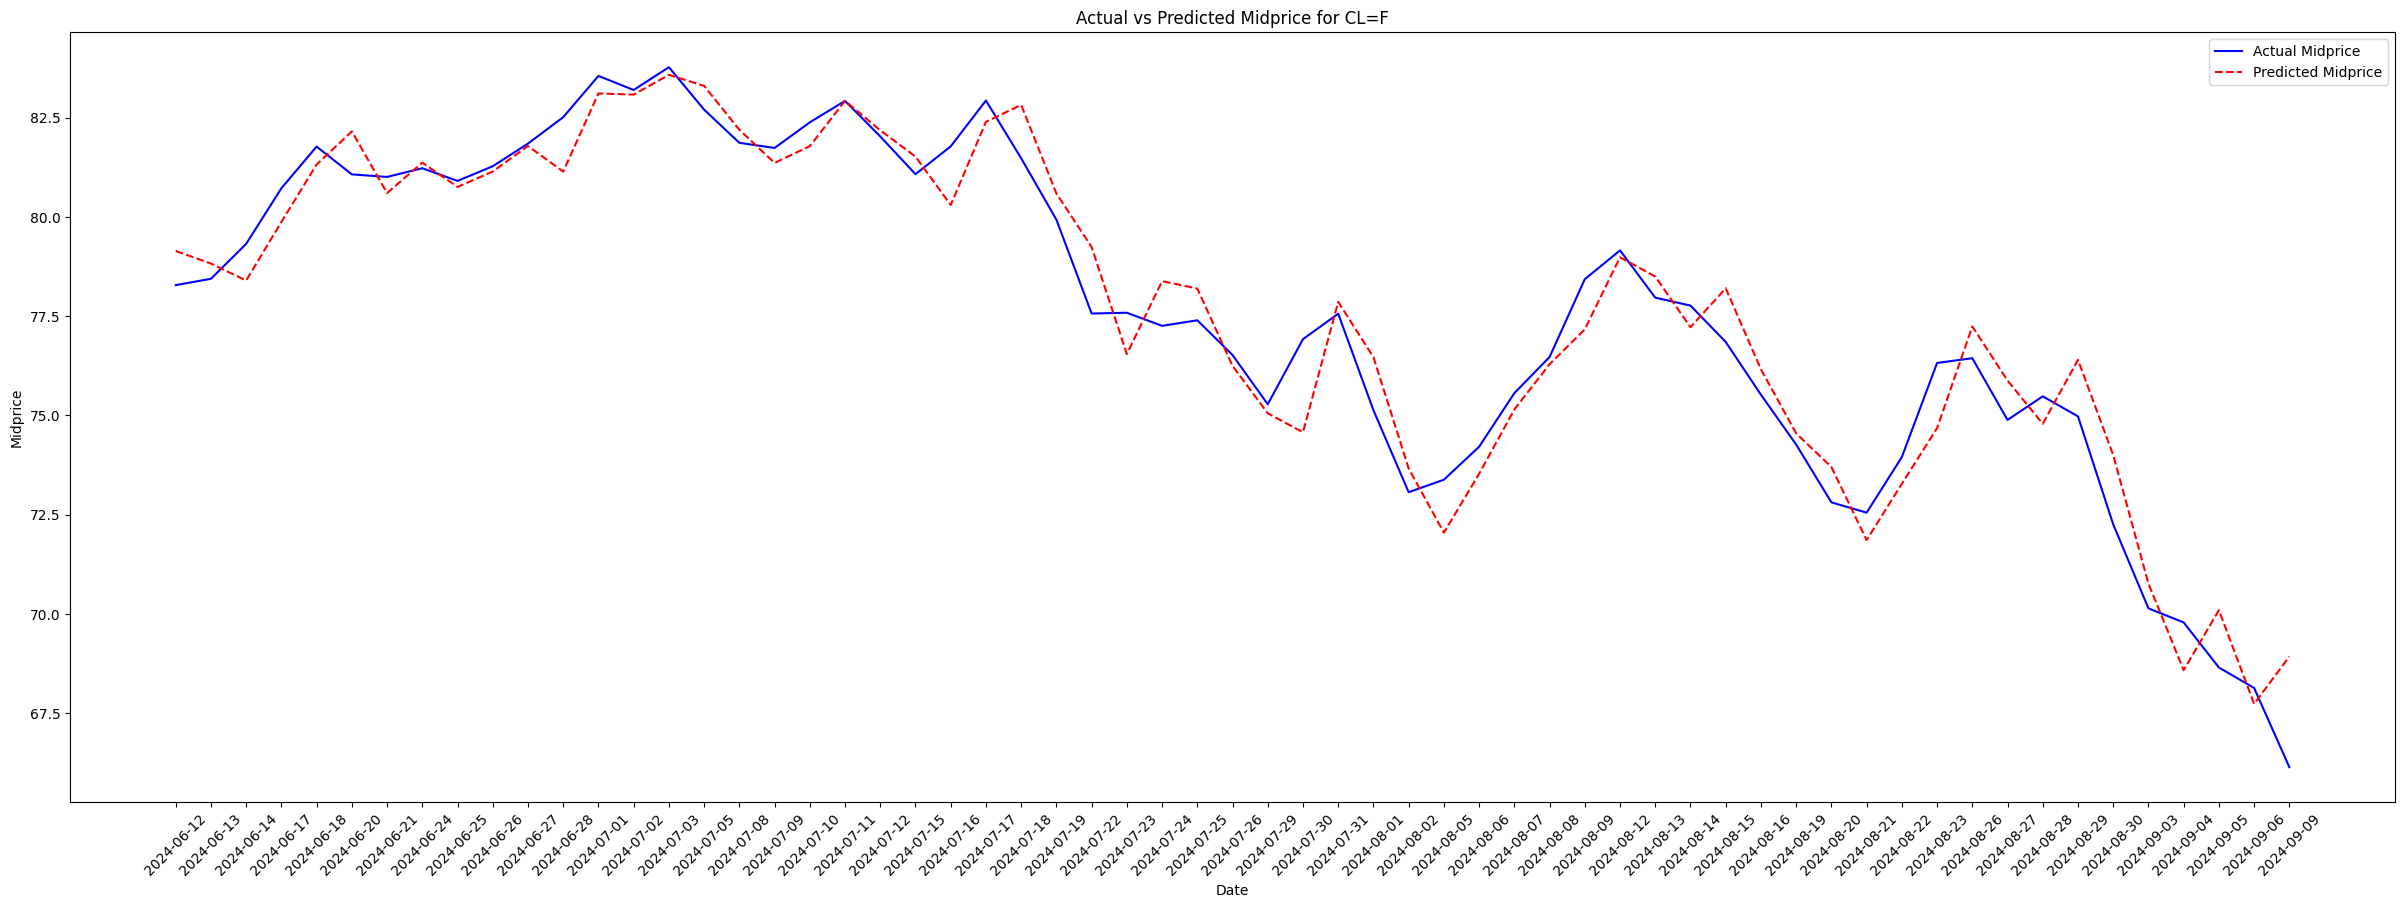

NVDA at 2024-06-12 , Actual Price: 3.7550048828125, xbregressor_result: [1.0185899], xbclassifier_result: [1], final: [1.0185899]
NVDA at 2024-06-13 , Actual Price: 2.0999984741210938, xbregressor_result: [1.0185899], xbclassifier_result: [1], final: [1.0185899]
NVDA at 2024-06-14 , Actual Price: 1.0749969482421875, xbregressor_result: [1.0358258], xbclassifier_result: [1], final: [1.0358258]
NVDA at 2024-06-17 , Actual Price: 1.8550033569335935, xbregressor_result: [1.0862455], xbclassifier_result: -1, final: [1.0862455]
NVDA at 2024-06-18 , Actual Price: 1.6299972534179688, xbregressor_result: [1.0185899], xbclassifier_result: [1], final: [1.0185899]
NVDA at 2024-06-20 , Actual Price: -7.674995422363281, xbregressor_result: [0.85990554], xbclassifier_result: [1], final: [0.85990554]
NVDA at 2024-06-21 , Actual Price: -6.215003967285156, xbregressor_result: [0.85990554], xbclassifier_result: -1, final: [0.85990554]
NVDA at 2024-06-24 , Actual Price: 1.6599998474121094, xbregressor_res

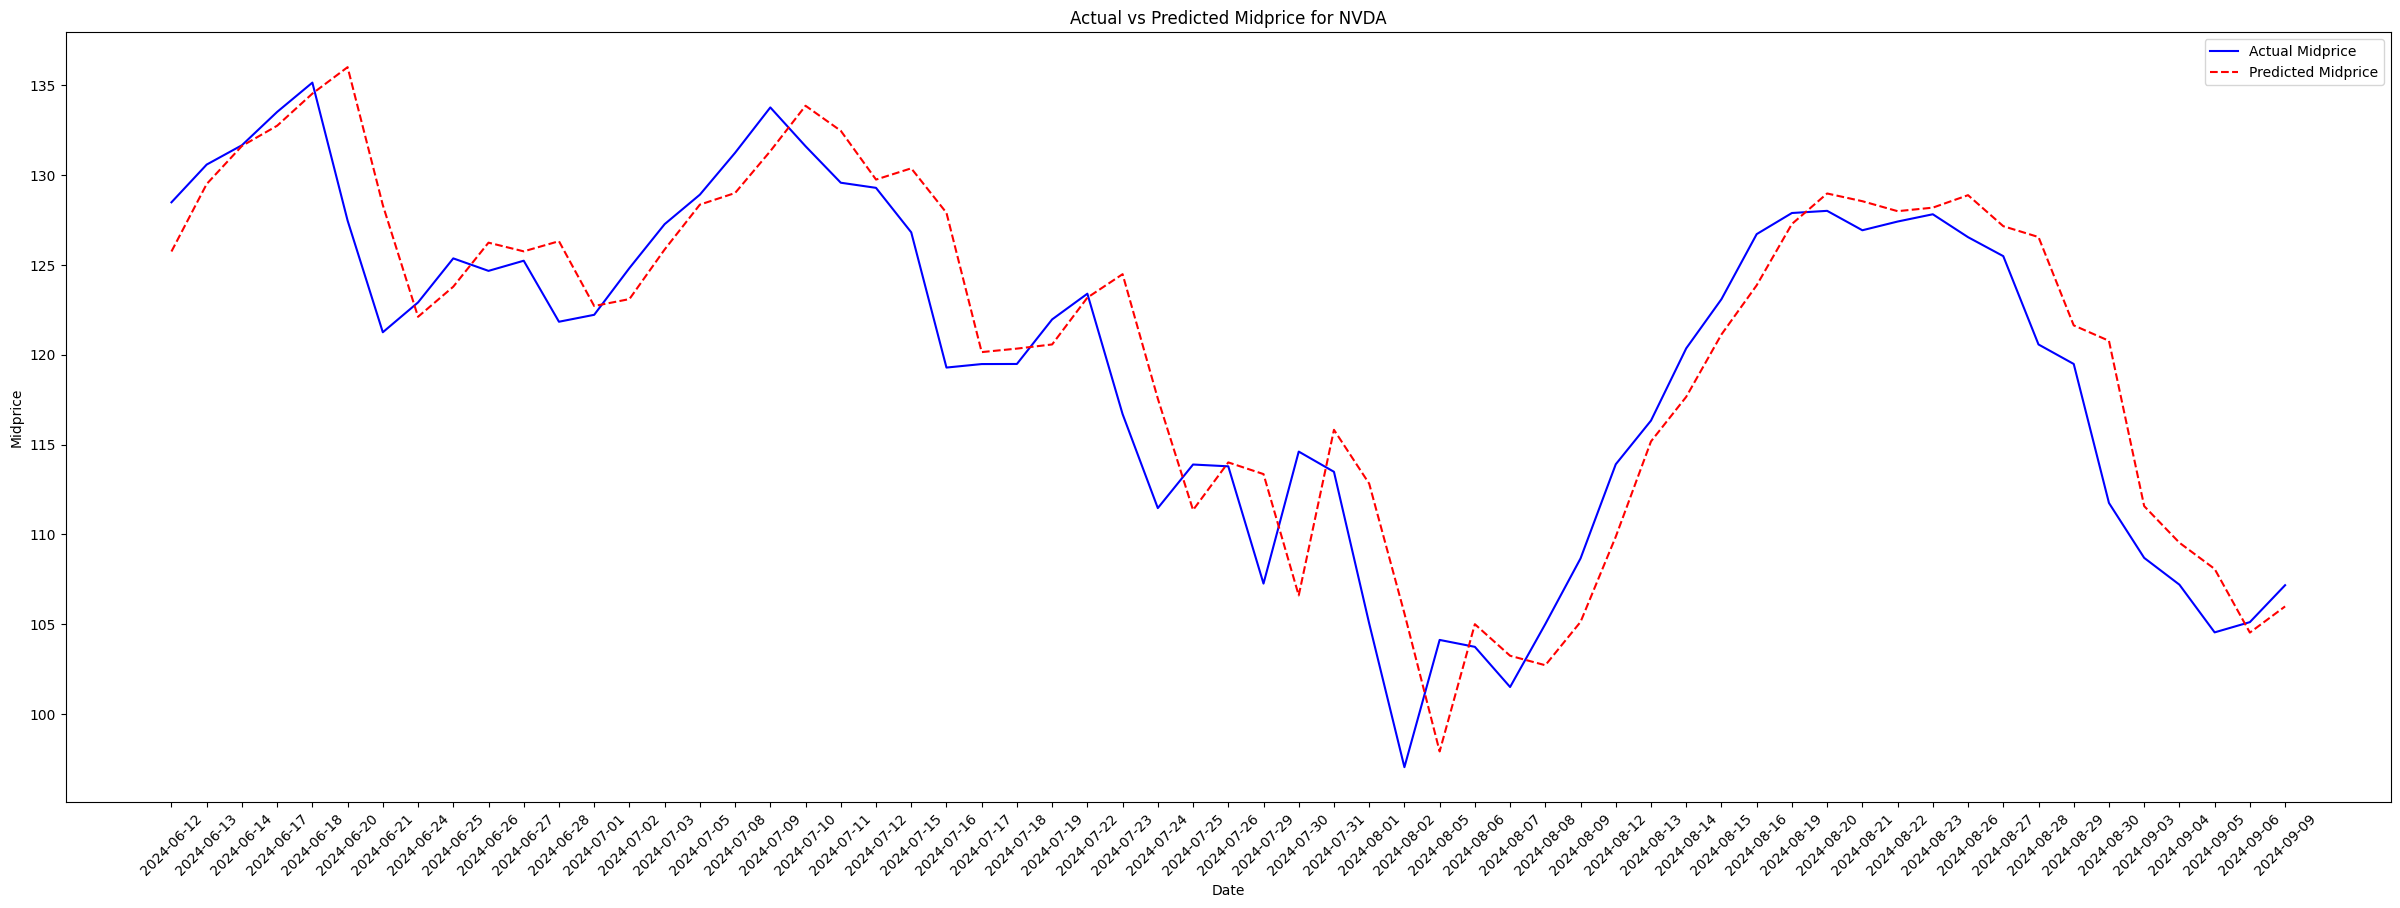

SGDUSD=X at 2024-06-13 , Actual Price: -0.0023589730262756, xbregressor_result: [3.0305222e-05], xbclassifier_result: [1], final: [3.0305222e-05]
SGDUSD=X at 2024-06-14 , Actual Price: -7.605552673339844e-05, xbregressor_result: [3.0305222e-05], xbclassifier_result: [1], final: [3.0305222e-05]
SGDUSD=X at 2024-06-17 , Actual Price: 1.7404556274414062e-05, xbregressor_result: [3.0305222e-05], xbclassifier_result: [1], final: [3.0305222e-05]
SGDUSD=X at 2024-06-18 , Actual Price: 0.001173049211502, xbregressor_result: [3.0305222e-05], xbclassifier_result: [1], final: [3.0305222e-05]
SGDUSD=X at 2024-06-19 , Actual Price: -0.0008939206600189, xbregressor_result: [3.0305222e-05], xbclassifier_result: [1], final: [3.0305222e-05]
SGDUSD=X at 2024-06-20 , Actual Price: -0.0010221302509307, xbregressor_result: [3.0305222e-05], xbclassifier_result: -1, final: [3.0305222e-05]
SGDUSD=X at 2024-06-21 , Actual Price: 0.0002277195453643, xbregressor_result: [3.0305222e-05], xbclassifier_result: -1, 

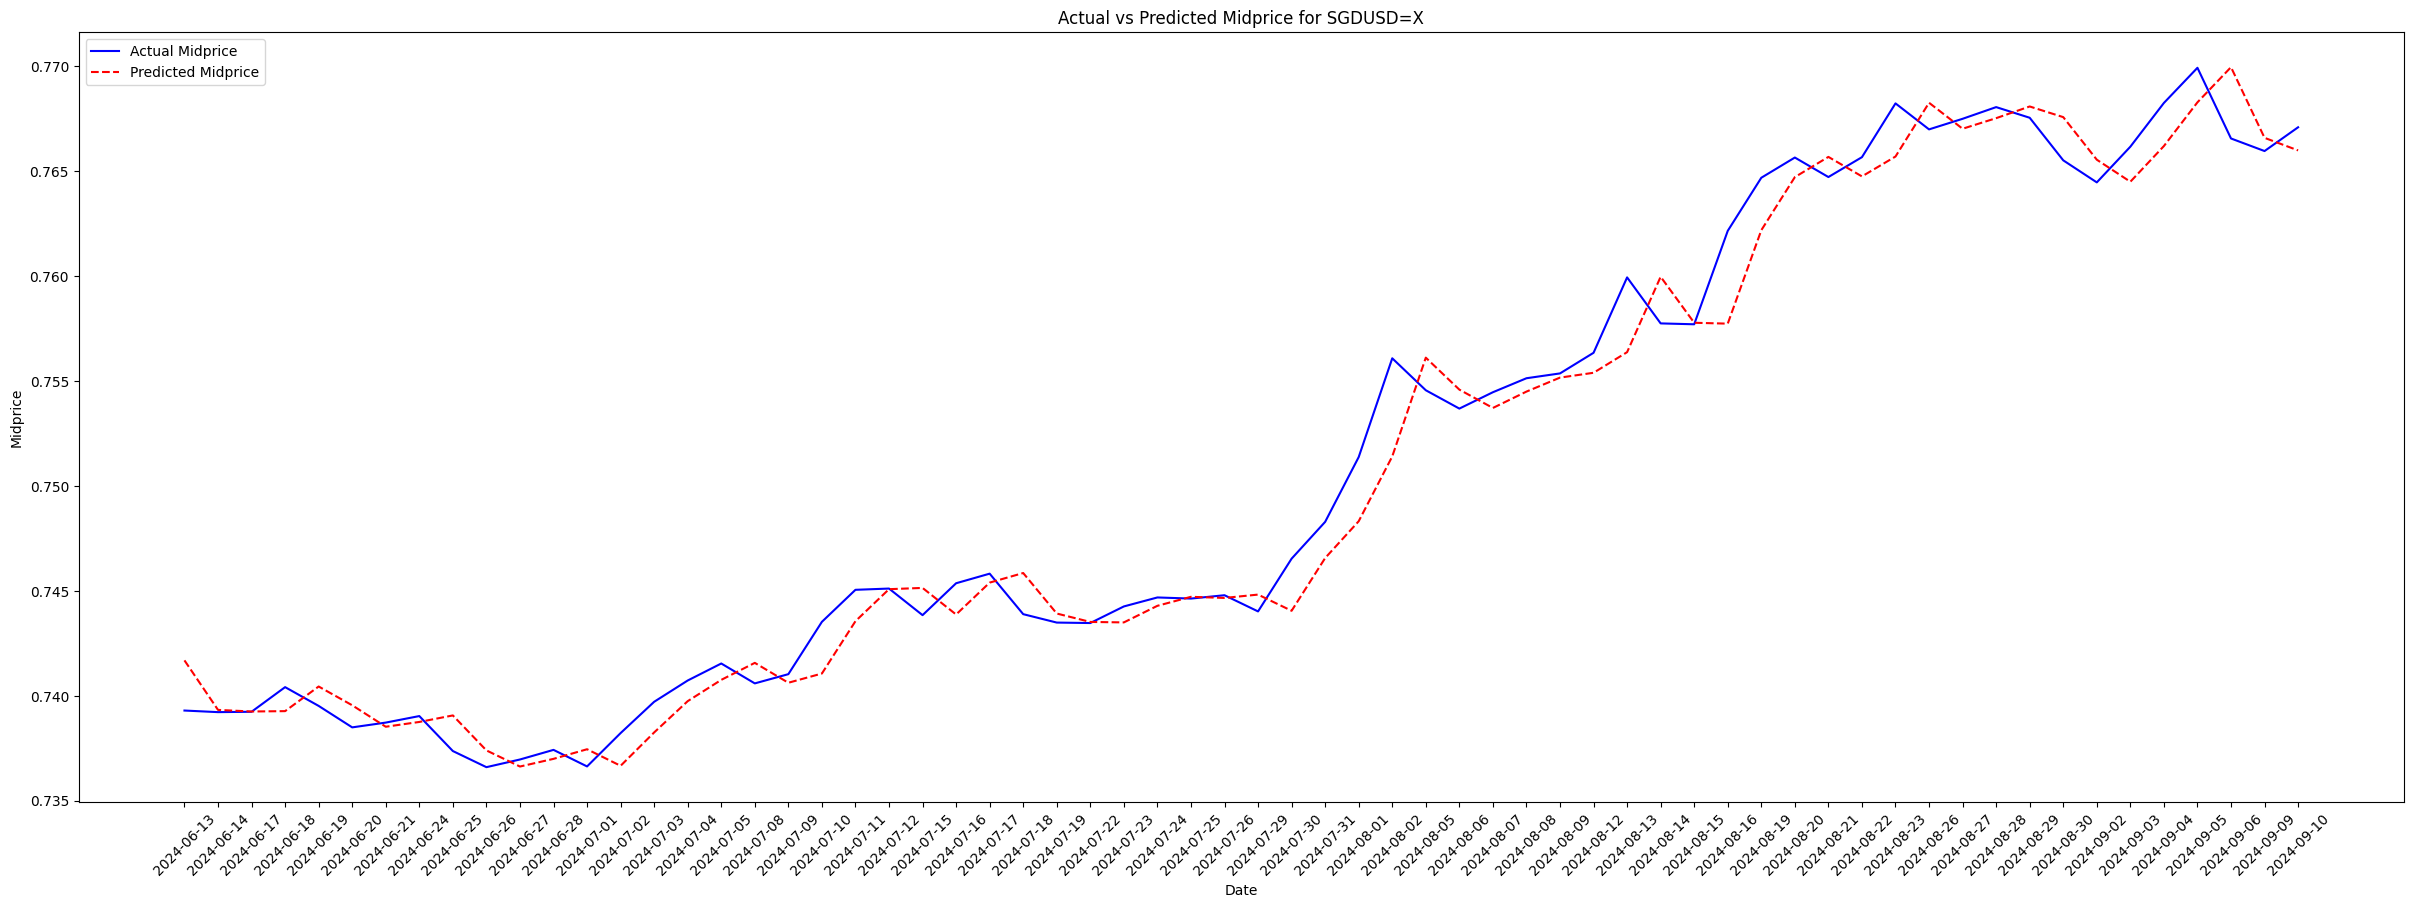

USDSGD=X at 2024-06-13 , Actual Price: 0.0043050646781921, xbregressor_result: [-5.8305028e-05], xbclassifier_result: -1, final: [-5.8305028e-05]
USDSGD=X at 2024-06-14 , Actual Price: 0.0001349449157714, xbregressor_result: [-5.8305028e-05], xbclassifier_result: -1, final: [-5.8305028e-05]
USDSGD=X at 2024-06-17 , Actual Price: -2.992153167724609e-05, xbregressor_result: [-5.8305028e-05], xbclassifier_result: -1, final: [-5.8305028e-05]
USDSGD=X at 2024-06-18 , Actual Price: -0.0021450519561767, xbregressor_result: [-5.8305028e-05], xbclassifier_result: -1, final: [-5.8305028e-05]
USDSGD=X at 2024-06-19 , Actual Price: 0.0016350150108337, xbregressor_result: [-5.8305028e-05], xbclassifier_result: -1, final: [-5.8305028e-05]
USDSGD=X at 2024-06-20 , Actual Price: 0.0018699765205383, xbregressor_result: [-5.8305028e-05], xbclassifier_result: [1], final: [-5.8305028e-05]
USDSGD=X at 2024-06-21 , Actual Price: -0.0004149675369262, xbregressor_result: [-5.8305028e-05], xbclassifier_result:

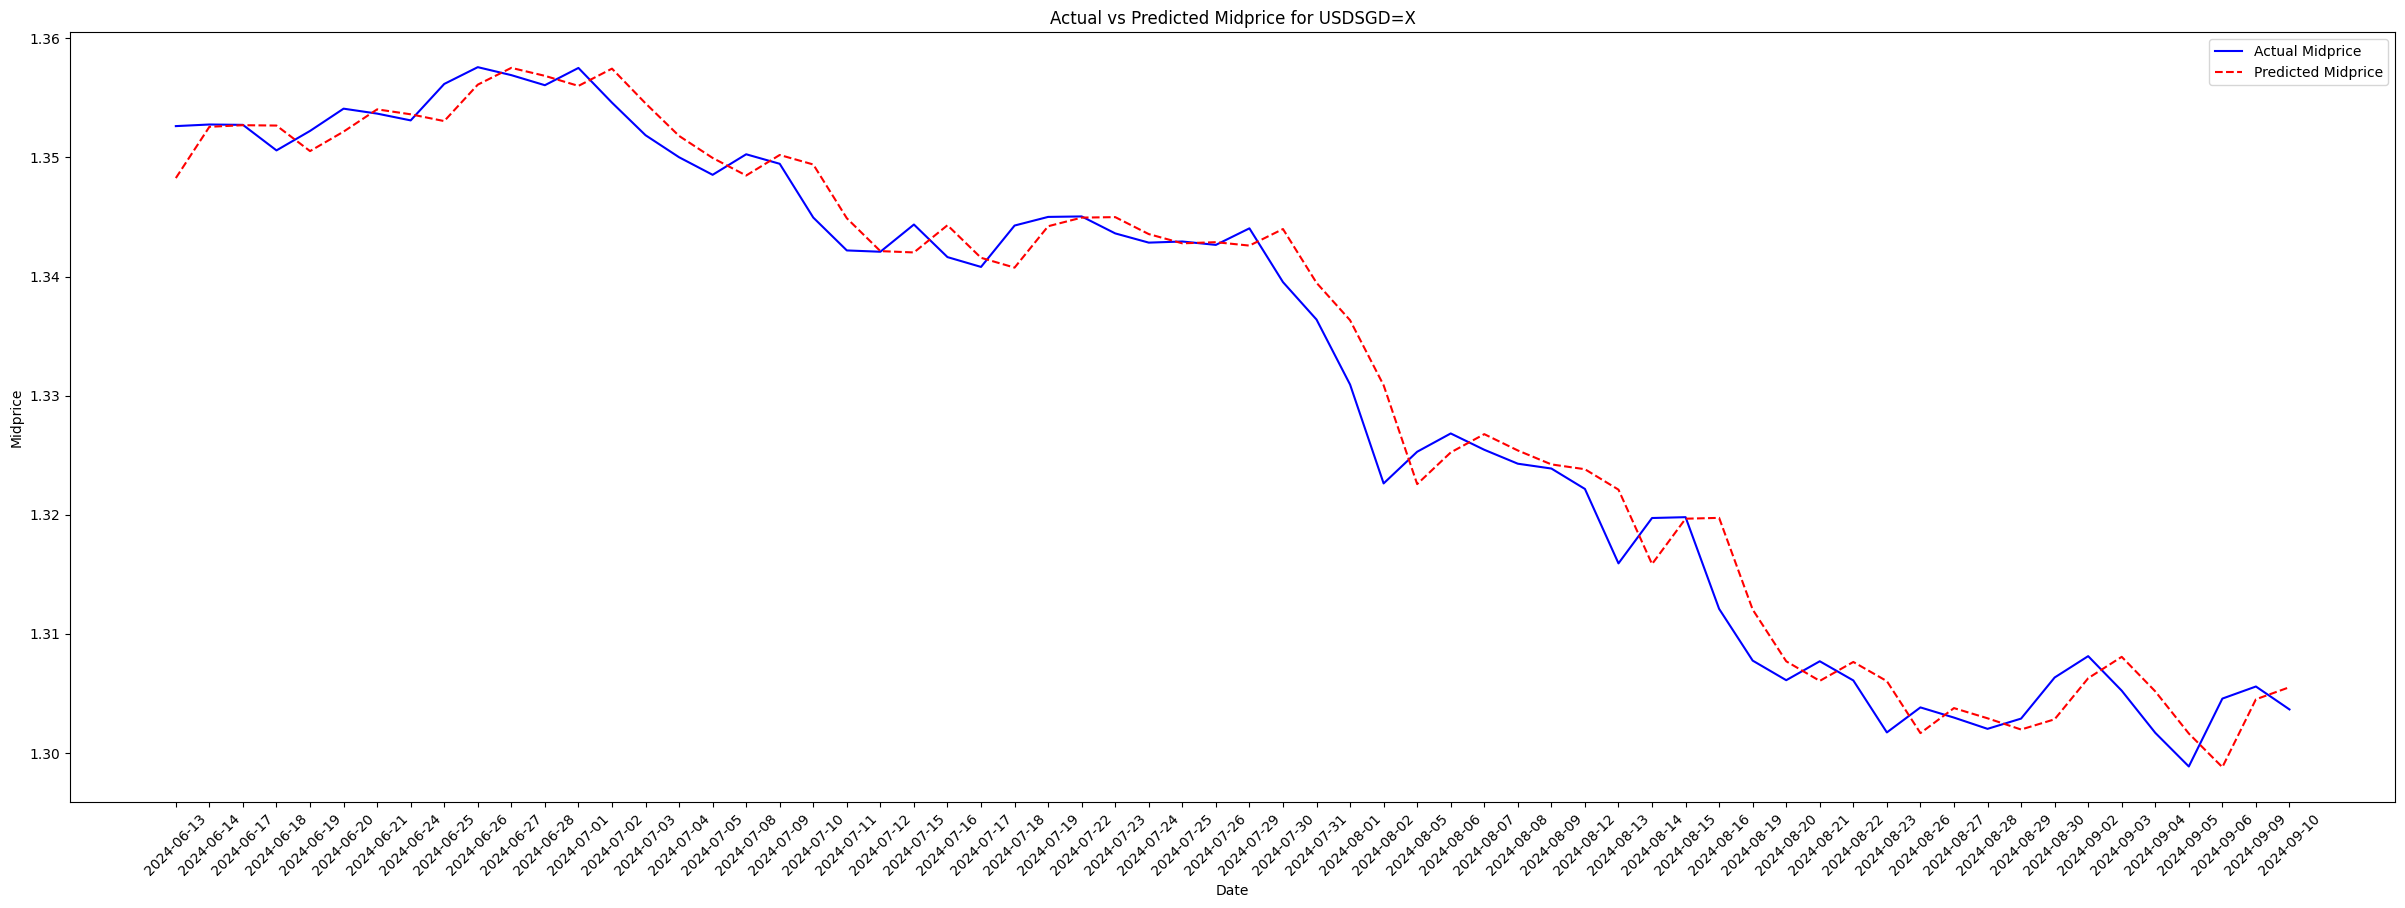

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the necessary functions defined elsewhere:
# xbclassifier_predict, xbregressor_predict, root_mean_squared_error

for ticker_symbol in ticker_list:
    dataframe = pd.read_csv(f"../data/test/{ticker_symbol}.csv")

    X = dataframe.copy(deep=True)

    # Drop columns from index 7 to 72
    X.drop(X.columns[73:93], axis=1, inplace=True)
    X.drop(X.columns[7:73], axis=1, inplace=True)
    
    # Drop the specified columns from X
    X.drop(columns=[
        'NEXT_DAY_CLOSEPRICE', 'DAILY_CLOSEPRICE_CHANGE', 'DAILY_CLOSEPRICE_CHANGE_PERCENT', 'DAILY_CLOSEPRICE_DIRECTION',
        'DAILY_MIDPRICE', 'NEXT_DAY_MIDPRICE', 'DAILY_MIDPRICE_CHANGE', 'DAILY_MIDPRICE_CHANGE_PERCENT', 'DAILY_MIDPRICE_DIRECTION', 
        'Date', 'Volume', 'Adj Close'
    ], inplace=True)


    sign_correct = 0
    total_predictions = 0
    actual_changes = []
    predicted_changes = []
    predicted_midprice = []

    # Loop through the dataframe starting from row 31 (index 30) to the second-to-last row
    for index, row in X.iloc[30:-1].iterrows():
        row_data = row.to_frame().T.reset_index(drop=True)  # Convert row to DataFrame and reset index
        
        xbclassifier_result = xbclassifier_predict(row_data, ticker_symbol)
        if xbclassifier_result == 0:
            xbclassifier_result = -1  # Adjust predicted_sign if it is 0
        
        xbregressor_result = xbregressor_predict(row_data, ticker_symbol)
        #predicted_value = abs(xbregressor_result) * xbclassifier_result
        predicted_value = xbregressor_result
        
        predicted_midprice.append(dataframe.iloc[index]['DAILY_MIDPRICE'] + predicted_value)

        actual_change = dataframe.iloc[index]['DAILY_MIDPRICE_CHANGE']
        actual_sign = np.sign(actual_change)
        
        # Collect actual and predicted changes for RMSE calculation
        actual_changes.append(actual_change)
        predicted_changes.append(predicted_value)

        #predicted_sign = xbclassifier_result
        predicted_sign = np.sign(xbregressor_result)
        
        # Check if the predicted sign matches the actual sign
        if predicted_sign == actual_sign:
            sign_correct += 1
        total_predictions += 1

        print(f"{ticker_symbol} at {dataframe.iloc[index]['Date']} , Actual Price: {actual_change}, xbregressor_result: {xbregressor_result}, xbclassifier_result: {xbclassifier_result}, final: {predicted_value}")

    # Calculate sign accuracy
    sign_accuracy = sign_correct / total_predictions
    print(f"{ticker_symbol} Sign Accuracy: {sign_accuracy}")

    # Calculate RMSE
    rmse = root_mean_squared_error(actual_changes, predicted_changes)
    print(f"{ticker_symbol} RMSE: {rmse}")

    # Predict the last entry
    last_row = X.iloc[-1].to_frame().T.reset_index(drop=True)
    last_xbclassifier_result = xbclassifier_predict(last_row, ticker_symbol)
    if last_xbclassifier_result == 0:
        last_xbclassifier_result = -1  # Adjust predicted_sign if it is 0
    
    last_xbregressor_result = xbregressor_predict(last_row, ticker_symbol)
    last_predicted_value = abs(last_xbregressor_result) * last_xbclassifier_result 

    print(f"{ticker_symbol} at {dataframe.iloc[-1]['Date']} , Predicted Price: {last_predicted_value}")

    # Plotting the results for each ticker
    plt.figure(figsize=(30, 10))

    # Plot actual midprice
    plt.plot(dataframe.iloc[30:-1]['Date'], dataframe.iloc[30:-1]['NEXT_DAY_MIDPRICE'], label='Actual Midprice', color='blue')

    # Plot predicted midprice
    plt.plot(dataframe.iloc[30:-1]['Date'], predicted_midprice, label='Predicted Midprice', color='red', linestyle='--')

    # Add title and labels
    plt.title(f'Actual vs Predicted Midprice for {ticker_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Midprice')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

